# Epidemic simulation on a graph

The goal is to learn the network characteristics and disease dynamics of the pandemic occurred in Sweden during 2009, commonly known as [swine flu](https://en.wikipedia.org/wiki/2009_swine_flu_pandemic). As a secondary goal, we develop an algorithm to simulate an epidemic on a random graph of choice according to the SIR and SIRV models.

In [1]:
from simulation.plot.plot import sir_plot, ni_plot, ninv_plot, ni_comparison_plot
from simulation.model.search import ParameterSearch
from simulation.network import generator
from simulate import simulate, sweden_parameter_search

## Epidemic on a known graph

The first warm-up problem consists in simulating an epidemic on a symmetric $k$-regular undirected graph $\mathcal{G}$ with $|\mathcal{V}|=500$ nodes and $k=4$ for $15$ weeks (steps). In this kind of graph, every node is connected to the $k$ nodes whose index is closest to their own modulo $n$. The graph is unweighted and undirected.

Then, we define a discrete-time simplified version of the SIR epidemic model. Our network system simulates pairwise interactions and spontaneous mutations.

Consider the state space $\mathcal{A}=\{0, 1, 2\}$ corresponding respectively to **S** (susceptible), **I** (infected) and **R** (recovered) states. We can describe our system through a discrete-time Markov chain $X(t)$ on the configuration space $\mathcal{X}=\mathcal{A}^\mathcal{V}$ defined by an initial distribution $x$ and a transition probability matrix $P$.

We define the following objects.
* The probability $\beta \in [0, 1]$ that the infection is spread from an infected individual **I** to a susceptible one **S**, given that they are connected by a link, during one time step.
* The probability $\rho \in [0, 1]$ that an infected individual **I** will recover, i.e., mutate its state into **R**, during one time step.

The epidemic is driven by the following transition probabilities. Consider a node $i\in\mathcal{V}$.

* If node $i$ is susceptible **S** at time $t$, then:
    * $\mathbb{P}(X_i(t+1)=\text{S} \:\vert\: X_i(t)=\text{S},\; \sum_{j\in\mathcal{V}}W_{ij}\delta^I_{X_j(t)}=m) = (1-\beta)^m$, where:
        * $\sum_{j\in\mathcal{V}}W_{ij}\delta^I_{X_j(t)}$ is the number of infected neighbors for node $i$
        * $(1-\beta)^m$ is the probability that node $i$ does *not* get infected by any of the neighbors during one time step
    * $\mathbb{P}(X_i(t+1)=\text{I} \:\vert\: X_i(t)=\text{S},\; \sum_{j\in\mathcal{V}}W_{ij}\delta^I_{X_j(t)}) = 1-(1-\beta)^m$
    * $\mathbb{P}(X_i(t+1)=\text{R} \:\vert\: X_i(t)=\text{S}) = 0$
* If node $i$ is infected **I** at time $t$, then:
    * $\mathbb{P}(X_i(t+1)=\text{S} \:\vert\: X_i(t)=\text{I}) = 0$
    * $\mathbb{P}(X_i(t+1)=\text{I} \:\vert\: X_i(t)=\text{I}) = 1-\rho$
    * $\mathbb{P}(X_i(t+1)=\text{R} \:\vert\: X_i(t)=\text{I}) = \rho$
* If node $i$ is recovered **R** at time $t$, then:
    * $\mathbb{P}(X_i(t+1)=\text{S} \:\vert\: X_i(t)=\text{R}) = 0$
    * $\mathbb{P}(X_i(t+1)=\text{I} \:\vert\: X_i(t)=\text{R}) = 0$
    * $\mathbb{P}(X_i(t+1)=\text{R} \:\vert\: X_i(t)=\text{R}) = 1$
    
Our implementation of the discrete-time SIR model takes any graph $\mathcal{G}$ and runs an epidemic simulation with parameters $\beta$, $\rho$ and number of initially infected individuals for a given number of steps.

We consider the time interval between one discrete step and another to be a week. More precisely, when the simulation is at step $t$, we are effectively simulating interactions and mutations that are occurring during week $t$, i.e., during the time interval $(t-1, t]$. The effects of the interactions and mutations that occurred during the time interval $(t-1, t]$ are reflected in the discrete time step $t$. For clarity, suppose we are at step $t=7$ of our simulation. This means that we are currently simulating week $7$, i.e., the events that occur during the time interval $(6, 7]$.

Note that the initial time instant $t=0$ does not refer to any week, but represents a single point in time where the simulation starts. Thus, for instance, simulating $15$ steps means running the algorithm from time step $t=0$ (i.e., the initial configuration) to $t=15$, for a total of 16 discrete time steps.

We run the discrete-time simplified version of the SIR model 100 times for $15$ weeks, with parameters $\beta = 0.3$ and $\rho = 0.7$, on the k-regular graph we previously generated. For each of these simulations, we choose a different initial configuration with $10$ different infected nodes randomly chosen on $\mathcal{G}$ according to a uniform distribution. The other nodes are all susceptible.

In [2]:
s, i, r, ni = simulate(iterations=100,
                       graph_generator=generator.k_regular,
                       graph_params={'k': 4},
                       n_nodes=500,
                       beta=0.3,
                       rho=0.7,
                       steps=15,
                       n_infected_init=10)

We draw plots representing the average number of newly infected individuals each week, and the average total number of susceptible, infected and recovered individuals each week. Recall that each discrete time step, from $t=1$ to $t=15$, reflects the effects that week $t$ had on the population.

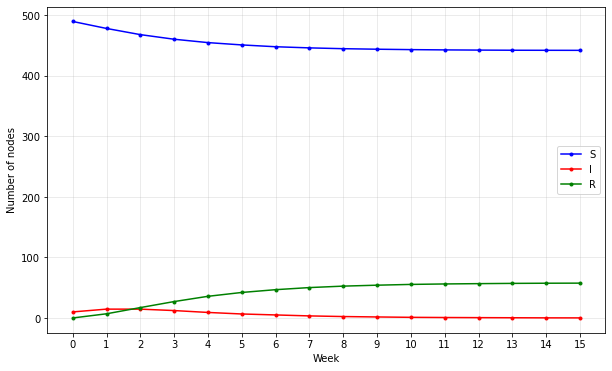

In [3]:
sir_plot(s, i, r)

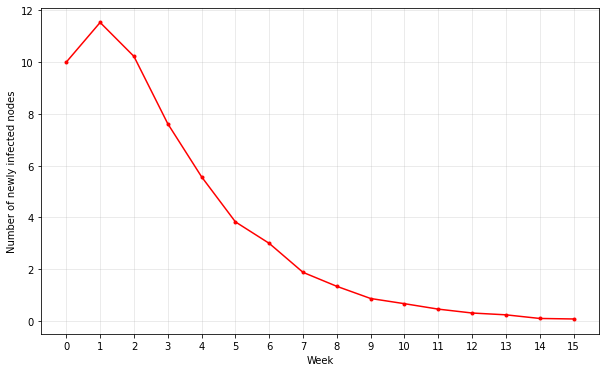

In [4]:
ni_plot(ni)

The previous simulation shows how nodes that are initialized randomly on the graph behave and extend the infection. The epidemic slows down early and does not reach new nodes fast enough to infect most individuals in the population.

## Simulate a pandemic without vaccination

The following problem consists in simulating an epidemic based on the discrete-time SIR model using a different graph model, namely the *preferential attachment model*. We perform 100 simulations of this type and plot the average total number of susceptible, infected and recovered individuals each week and the average number of newly infected individuals each week.

The preferential attachment graph has the following structure. Start with an initial graph $\mathcal{G}_1$ which is complete with $k+1$ nodes. Then, at each subsequent time step $t$, we create a new graph $\mathcal{G}_t$ by adding a new node to $\mathcal{G}_{t-1}$ and connecting it to some of its existing nodes, according to a *preferential attachment* rule.

This rule says that at each time step $t$, the new node $n_t$ will have a degree $w_{n_t}(t)=\frac{k}{2}$. The nodes to which $n_t$ should connect are chosen according to the following probability rule.

The probability that there will be a link between node $n_t$ and node $i\in\mathcal{V}_{t-1}$ is:

$$
\mathbb{P}(W_{n_t,i}(t)=W_{i,n_t}(t)=1 \:\vert\: \mathcal{G}_{t-1}) = \frac{w_i(t-1)}{\sum_{j\in\mathcal{V}_{t-1}} w_j(t-1)}, \qquad i\in\mathcal{V}_{t-1}
$$

Each of the 100 simulations consists in the following steps.
* Generate a random graph according to the *preferential attachment model*, with average degree close to $k$.
* Simulate an epidemic according to the simplified version of the SIR model.

The parameters of the simulations, i.e., $k$, number of nodes, $\beta$, $\rho$, number of steps and number of initially infected individuals are fixed for all 100 simulations.

In our simulations, we generate a graph with average degree $k=6$ and $500$ nodes. We set $\beta=0.3$ and $\rho=0.7$, and carry out each simulation for $15$ weeks, with an initial configuration of $10$ infected nodes.

In [5]:
s, i, r, ni = simulate(iterations=100,
                       graph_generator=generator.preferential_attachment,
                       graph_params={'k': 6},
                       n_nodes=500,
                       beta=0.3,
                       rho=0.7,
                       steps=15,
                       n_infected_init=10)

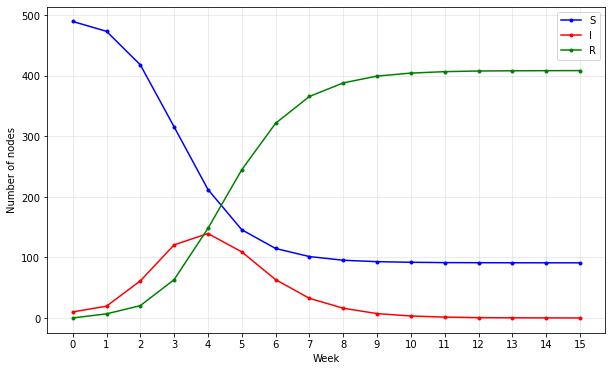

In [6]:
sir_plot(s, i, r)

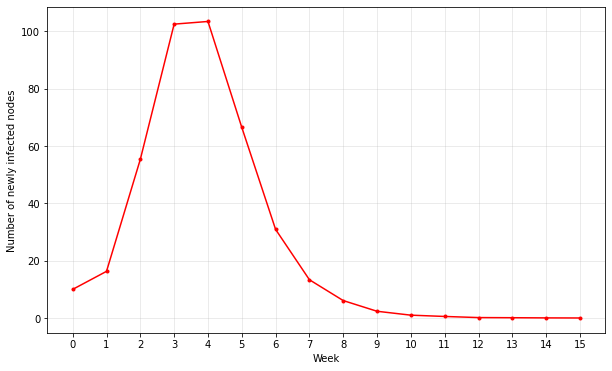

In [7]:
ni_plot(ni)

## Simulate a pandemic with vaccination

We introduce a modified SIR model which takes into account **vaccinated individuals** as a separate state **V**. Vaccinated individuals are not able to become infected nor infect any other individual.

The state space becomes $\mathcal{A}=\{0, 1, 2, 3\}$ corresponding to **S** (susceptible), **I** (infected), **R** (recovered) and **V** (vaccinated) states.

The number of nodes to vaccinate is determined by the array $\text{Vacc}(t)$. This array represents the total fraction of population that has received vaccination *by* each week. It starts from $t=1$, i.e., the first element of the array refers to the fraction of population that has received vaccination *by* week 1. To clarify this interpretation, we consider the following vaccination array.

$$\text{Vacc}(t) = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]$$

According to this array, $55\%$ of the population has received vaccination *by* week 7, i.e., in the time period that goes from the instant in which the simulation begins to the last instant of the 6th week, and $5\%$ of the population has received vaccination *during* week 7. Since we assume that the vaccination takes effect immediately once given, the nodes that receive vaccination during week 7 will not be able to become infected nor infect any other node in that same week 7, regardless of the state they were in immediately before the beginning of week 7.

We simulate an epidemic based on the discrete-time SIR model with vaccination (SIRV). We perform 100 simulations of this type and plot the average total number of susceptible, infected, recovered and vaccinated individuals each week and the average number of newly infected and newly vaccinated individuals each week.

In each of the 100 simulations, we generate a graph with average degree $k=6$ and $500$ nodes and simulate $15$ weeks with parameters $\beta=0.3$, $\rho=0.7$ and an initial configuration of $10$ randomly chosen infected nodes. These settings are exactly the same as the previous simulation without vaccination, so results are more easily comparable. In addition, we specify the total fraction of population that has received vaccination by each week according to the following array.
$$\text{Vacc}(t) = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]$$

In [8]:
vaccination_vector = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]

s, i, r, v, ni, nv = simulate(iterations=100,
                              graph_generator=generator.preferential_attachment,
                              graph_params={'k': 6},
                              n_nodes=500,
                              beta=0.3,
                              rho=0.7,
                              steps=15,
                              n_infected_init=10,
                              vacc=vaccination_vector)

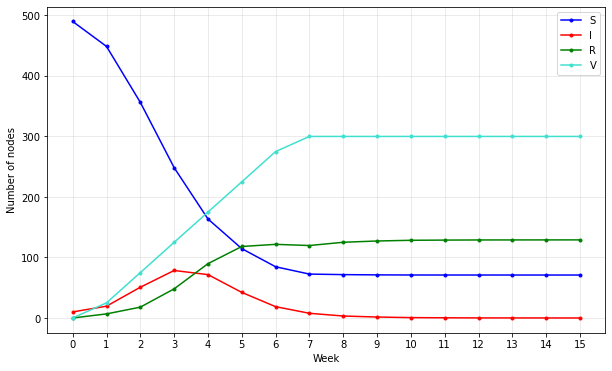

In [9]:
sir_plot(s, i, r, v)

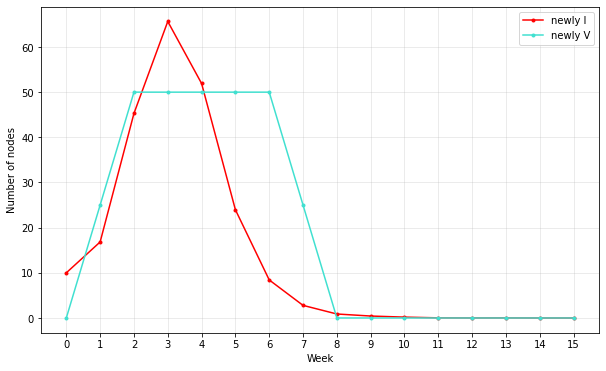

In [10]:
ninv_plot(ni, nv)

## The H1N1 pandemic in Sweden 2009

Our goal is to estimate parameters $k$, $\beta$ and $\rho$ for our model which best match the **H1N1 pandemic in Sweden in 2009**, which we simulate for $15$ weeks. The fraction of population that had received vaccination during these weeks is reported in the following vector.

$$\text{Vacc}(t)=[5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60]$$

The population of Sweden is scaled down to $934$ nodes. The number of newly infected individuals each week in the $15$-week period from week 42, 2009 to week 5, 2010 is reported in the following vector.
$$I_0(t)=[1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]$$

To estimate the parameters that best match the real pandemic, we define an **algorithm** which performs a **gradient-based search** over the parameter space of $k$, $\beta$ and $\rho$. The distance between our simulation and the real pandemic is measured through the root-mean-square error (RMSE) between the number of infected individuals each week $I(t)$ of the simulation and the number of infected individuals each week $I_0(t)$ of the real pandemic. This is the *cost function* of our algorithm.

$$\text{RMSE} = \sqrt{\frac{1}{n_\text{weeks}} \sum_{t=1}^{n_\text{weeks}} \left(I(t)-I_0(t)\right)^2 }\qquad \text{with}\; n_\text{weeks}=15\;\text{steps of the simulation}$$ 


### Basic parameter search algorithm
The basic version of the algorithm is the following.
1. Fix an initial guess of the parameters $k_0=10$, $\beta_0=0.3$, $\rho_0=0.6$ and define $\Delta k=1$, $\Delta \beta = 0.1$, $\Delta \rho=0.1$.
2. Construct the search space as a list of $3*3*3=27$ parameter sets, given by $\{k_0-\Delta k, k_0, k_0+\Delta k\} \times \{\beta_0-\Delta \beta, \beta_0, \beta_0+\Delta \beta\} \times \{\rho_0-\Delta \rho, \rho_0, \rho_0+\Delta \rho\}$.
3. For each parameter set $(k, \beta, \rho)$:
    1. Generate a random graph using preferential attachment with average degree $k$ and $934$ nodes.
    2. Simulate the pandemic 10 times, using the SIRV model with the given parameters.
    3. Compute the average number of newly infected individuals each week, $I(t)$.
    4. Compute the RMSE between the simulation and the real pandemic.
4. Update $k_0$, $\beta_0$, $\rho_0$ to the set of parameters yielding the lowest RMSE.
5. If the result was a different set of parameters from the previous $k_0$, $\beta_0$, $\rho_0$ go to 2. Otherwise, stop.

We run our algorithm three times and save the parameter set associated with the lowest RMSE. 

**Run 1**

In [11]:
sweden_parameter_search(basic=True)

Iteration 1 params={'k': 10, 'beta': 0.3, 'rho': 0.6}
Lowest loss 7.409768327462517 for grid set {'beta': 0.19999999999999998, 'k': 9, 'rho': 0.6}
Iteration 2 params={'beta': 0.19999999999999998, 'k': 9, 'rho': 0.6}
Lowest loss 6.137426170635375 for grid set {'beta': 0.19999999999999998, 'k': 9, 'rho': 0.5}
Iteration 3 params={'beta': 0.19999999999999998, 'k': 9, 'rho': 0.5}
Lowest loss 6.798284097231202 for grid set {'beta': 0.19999999999999998, 'k': 9, 'rho': 0.6}
Iteration 4 params={'beta': 0.19999999999999998, 'k': 9, 'rho': 0.6}
Lowest loss 4.507697120851549 for grid set {'beta': 0.19999999999999998, 'k': 8, 'rho': 0.7}
Iteration 5 params={'beta': 0.19999999999999998, 'k': 8, 'rho': 0.7}
Lowest loss 5.490840858496386 for grid set {'beta': 0.3, 'k': 7, 'rho': 0.7}
Iteration 6 params={'beta': 0.3, 'k': 7, 'rho': 0.7}
Lowest loss 5.33735265214257 for grid set {'beta': 0.19999999999999998, 'k': 8, 'rho': 0.7}
Iteration 7 params={'beta': 0.19999999999999998, 'k': 8, 'rho': 0.7}
Lowest 

{'beta': 0.19999999999999998, 'k': 7, 'rho': 0.6}

**Run 2**

In [12]:
sweden_parameter_search(basic=True)

Iteration 1 params={'k': 10, 'beta': 0.3, 'rho': 0.6}
Lowest loss 9.11175065506075 for grid set {'beta': 0.19999999999999998, 'k': 9, 'rho': 0.5}
Iteration 2 params={'beta': 0.19999999999999998, 'k': 9, 'rho': 0.5}
Lowest loss 6.93065653455717 for grid set {'beta': 0.19999999999999998, 'k': 8, 'rho': 0.5}
Iteration 3 params={'beta': 0.19999999999999998, 'k': 8, 'rho': 0.5}
Lowest loss 6.70253683316996 for grid set {'beta': 0.19999999999999998, 'k': 7, 'rho': 0.6}
Iteration 4 params={'beta': 0.19999999999999998, 'k': 7, 'rho': 0.6}
Lowest loss 3.6755045005187155 for grid set {'beta': 0.19999999999999998, 'k': 7, 'rho': 0.5}
Iteration 5 params={'beta': 0.19999999999999998, 'k': 7, 'rho': 0.5}
Lowest loss 5.33647823943844 for grid set {'beta': 0.19999999999999998, 'k': 6, 'rho': 0.4}
Iteration 6 params={'beta': 0.19999999999999998, 'k': 6, 'rho': 0.4}
Lowest loss 4.99959998399872 for grid set {'beta': 0.19999999999999998, 'k': 6, 'rho': 0.5}
Iteration 7 params={'beta': 0.19999999999999998

{'beta': 0.3, 'k': 5, 'rho': 0.6}

**Run 3**

In [13]:
sweden_parameter_search(basic=True)

Iteration 1 params={'k': 10, 'beta': 0.3, 'rho': 0.6}
Lowest loss 7.812511333325112 for grid set {'beta': 0.19999999999999998, 'k': 10, 'rho': 0.7}
Iteration 2 params={'beta': 0.19999999999999998, 'k': 10, 'rho': 0.7}
Lowest loss 6.342712353559793 for grid set {'beta': 0.19999999999999998, 'k': 10, 'rho': 0.7}
Best parameter set {'beta': 0.19999999999999998, 'k': 10, 'rho': 0.7} after 2 iteration(s)
Time elapsed: 899.6234831809998


{'beta': 0.19999999999999998, 'k': 10, 'rho': 0.7}

By looking at the logs of the three runs, we can make the following observations.

Firstly, the RMSE cost generally gets lower as more steps are taken. However it remains still quite high when the algorithm stops, indicating that the set of parameters that we found does not fit very well the real pandemic. Moreover, the three sets of optimal parameters are all different. This indicates that the variability of the experiment is quite high, and even by initializing the parameters to a fixed value and running 10 simulations per parameter set, we still have several sources of randomness, such as the graph generation and the evolution of the state of each node as weeks pass. This is further confirmed by the fact that different simulations on the same set of parameters may result in very different RMSE scores, and as a consequence, the path that the algorithm takes to an optimal parameter set is always different. Finally, if we observe the steps in each of the three runs, it is evident how the RMSE loss oscillates back and forth before settling on an optimal set of parameters, and in general, the algorithm has some problem in converging. In some cases, the lowest RMSE is not even the one found at the end of the simulation, but in one of the preceding steps. This may be due to the aforementioned variability of simulations, and also due to the algorithm finding a local optimum from which it is not able to escape.

Nonetheless, run 2 yielded the set of parameters $k=5$, $\beta=0.3$, $\rho=0.6$ associated with the lowest RMSE score, $5.02745$.

Our goal is to understand how well the model with optimal parameters actually fits the real epidemic. Therefore, we perform 100 simulations using the best set of parameters, and plot the average number of newly infected individuals each week compared to the true value of newly infected individuals each week $I_0(t)$, as well as the average total number of susceptible, infected, recovered and vaccinated individuals each week.

In [14]:
sweden_vaccination_vector = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60]

s, i, r, v, ni, nv = simulate(iterations=100,
                              graph_generator=generator.preferential_attachment,
                              graph_params={'k': 5},
                              n_nodes=934,
                              beta=0.3,
                              rho=0.6,
                              steps=15,
                              n_infected_init=1,
                              vacc=sweden_vaccination_vector)

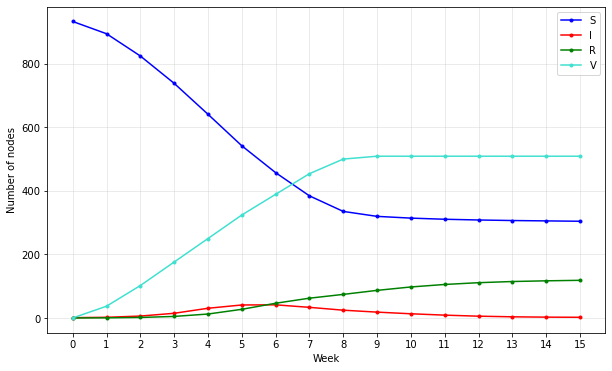

In [15]:
sir_plot(s, i, r, v)

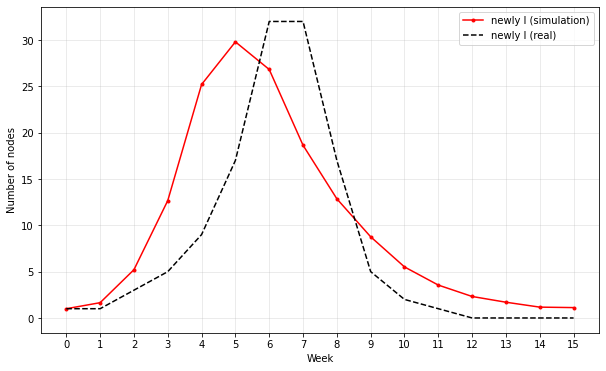

In [16]:
sweden_ni_target = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]

ni_comparison_plot(ni, sweden_ni_target)

The last plot clearly shows how the optimal parameter set that we found does not fit the real epidemic very well. The most evident problem is that the number of newly infected individuals rises too fast, reaching a peak at week 5, and subsequently drops too early without ever reaching the actual number of newly infected of the real pandemic in week 6-7. Moreover, the number of newly infected nodes remains too high as the epidemic fades, in contrast with the more severe drop of the real epidemic.

### Improvements to the basic algorithm

Considering the insights from the basic algorithm implementation, we try to identify possible weaknesses that cause the algorithm to converge to a suboptimal set of parameters.

A problem may be that the current parameter deltas do not offer a very high granularity in the grid search, especially for probabilities $\beta$ and $\rho$. This means that better optima may be found in between the current grid steps. Therefore, we introduce another step in our search algorithm. When the algorithm cannot find a better set of parameters for the first time, i.e., the best parameter set found in the second-to-last iteration is the same as the one found in the last iteration, we switch to a finer delta grid. More specifically, in the first step we keep $\Delta\beta=0.1$ and $\Delta\rho=0.1$, while in the second step we reduce the deltas to $\Delta\beta=0.025$ and $\Delta\rho=0.025$. We set $\Delta k=1$ in both steps. This will hopefully allow our algorithm to find a better parameter set for our model, by exploring new parts of the parameter space. However, a side effect of this strategy is the additional time needed to perform this second step.

Moreover, as we highlighted previously, one of the main problems with our algorithm is the inherent high variability of the simulations due to multiple randomness sources. This does not allow our search to easily converge to a parameter set, as it causes issues such as the oscillation of the RMSE score and different optimal parameter sets at each run. To try and mitigate this problem without losing generality, we apply a seed to our graph generator function. This makes the structure of the graph predictable for the same average degree $k$, allowing us to remove a source of randomness from the algorithm. We do *not* apply seeds to any other part of the algorithm, as they may cause overfitting problems.

In [17]:
sweden_parameter_search()

Iteration 1 params={'k': 10, 'beta': 0.3, 'rho': 0.6}
Lowest loss 8.399325369734562 for grid set {'beta': 0.19999999999999998, 'k': 9, 'rho': 0.6}
Iteration 2 params={'beta': 0.19999999999999998, 'k': 9, 'rho': 0.6}
Lowest loss 4.974736173909125 for grid set {'beta': 0.19999999999999998, 'k': 8, 'rho': 0.6}
Iteration 3 params={'beta': 0.19999999999999998, 'k': 8, 'rho': 0.6}
Lowest loss 5.921373714491145 for grid set {'beta': 0.19999999999999998, 'k': 7, 'rho': 0.7}
Iteration 4 params={'beta': 0.19999999999999998, 'k': 7, 'rho': 0.7}
Lowest loss 6.246438985534078 for grid set {'beta': 0.19999999999999998, 'k': 7, 'rho': 0.6}
Iteration 5 params={'beta': 0.19999999999999998, 'k': 7, 'rho': 0.6}
Lowest loss 3.0570137934483275 for grid set {'beta': 0.19999999999999998, 'k': 8, 'rho': 0.7}
Iteration 6 params={'beta': 0.19999999999999998, 'k': 8, 'rho': 0.7}
Lowest loss 4.198968127210938 for grid set {'beta': 0.19999999999999998, 'k': 8, 'rho': 0.7}
Switching to finer delta grid
Iteration 7 

{'beta': 0.19999999999999998, 'k': 8, 'rho': 0.725}

In [18]:
s, i, r, v, ni, nv = simulate(iterations=100,
                              graph_generator=generator.preferential_attachment,
                              graph_params={'k': 8},
                              n_nodes=934,
                              beta=0.2,
                              rho=0.725,
                              steps=15,
                              n_infected_init=1,
                              vacc=sweden_vaccination_vector)

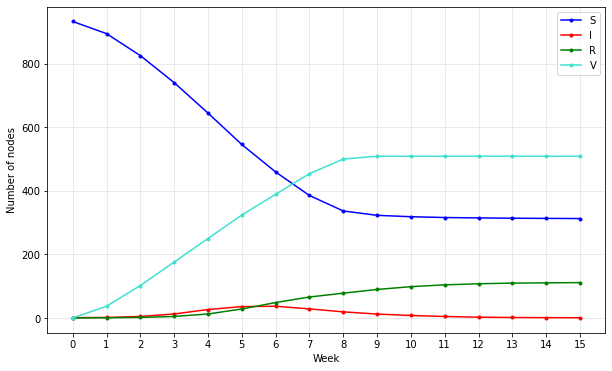

In [19]:
sir_plot(s, i, r, v)

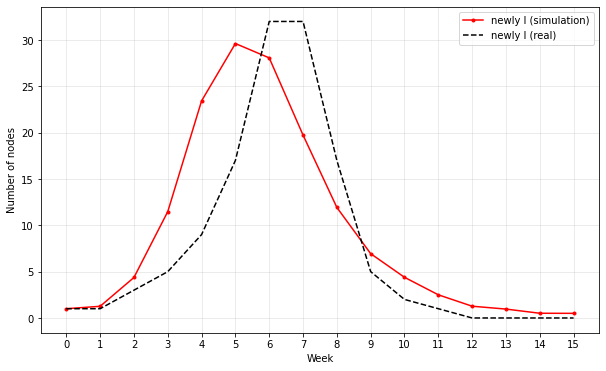

In [20]:
ni_comparison_plot(ni, sweden_ni_target)

As we can see from the last plot, this set of parameters fits the real epidemic only slightly better than the previous one. The plot is still skewed to the left, reaching its peak 1-2 weeks earlier, though the subsequent drop seems to fit the real pandemic better. However, the newly infected trend is not yet satisfactorily close to the real one.

Wrapping up, the difference between the parameter set obtained with the optimized search algorithm and the one obtained with the basic algorithm is very small, and the final RMSE is still quite high.

### Another type of random graph

A potential problem with our algorithm, which we did not tackle before, may be the partial inadequacy of the preferential attachment graph. This kind of graph may not model very well the social structure of the population of Sweden and the interactions between individuals which cause infection. In an attempt to solve this problem, we explore another other type of random graph and run a parameter search on it, with the goal of further lowering the RMSE score and find a better fit for the real epidemic.

This other graph model we evaluate is the **Newman-Watts-Strogatz small-world model**. This model generates a random graph as follows. Firstly, it creates a ring over the $n$ nodes of the graph, each node connected to $k$ neighbors, $\frac{k}{2}$ on each side (or $k-1$ if $k$ is odd). We denote this underlying graph with $\mathcal{G}_u$. Then, for each edge $(i, j)$ in the underlying graph $\mathcal{G}_u$, it adds an edge $(i, k)$ with a randomly chosen existing node $w$ with probability $p$. In the end, it generates a random graph $\mathcal{G}$. Note that this is different from the Watts-Strogatz model, which instead *rewires* existing edges.

In this case, the parameter grid is composed by four different parameters, namely $k$ (number of nearest neighbors of the underlying graph), $p$ (probability of creating a new edge), $\beta$ and $\rho$. This means that the search space is a list of $3*3*3*32=81$ parameter sets, given by $\{k_0-\Delta k, k_0, k_0+\Delta k\} \times \{p_0-\Delta p, p_0, p_0+\Delta p\} \times \{\beta_0-\Delta \beta, \beta_0, \beta_0+\Delta \beta\} \times \{\rho_0-\Delta \rho, \rho_0, \rho_0+\Delta \rho\}$.

Because of the size of the search space, the algorithm may take a long time to run all the simulations. Nonetheless, we go ahead by setting initial guesses $k_0 = 8$, $p_0 = 0.5$, $\beta_0 = 0.3$ and $\rho_0 = 0.6$ and running the search.

In [21]:
ps = ParameterSearch(generator.newman_watts_strogatz,
                     generator.newman_watts_strogatz_check,
                     n_nodes=934,
                     steps=15,
                     n_infected_init=1,
                     vacc=sweden_vaccination_vector,
                     ni_target=sweden_ni_target)

graph_initial_params = {"k": 8, "p": 0.5}
epidemic_initial_params = {"beta": 0.3, "rho": 0.6}

graph_delta_params = {"k": 2, "p": 0.1}
epidemic_delta_params = {"beta": 0.1, "rho": 0.1}

graph_delta_fine_params = {"k": 1, "p": 0.025}
epidemic_delta_fine_params = {"beta": 0.025, "rho": 0.025}

ps.search(graph_initial_params,
          epidemic_initial_params,
          graph_delta_params,
          epidemic_delta_params,
          graph_delta_fine_params,
          epidemic_delta_fine_params,
          simulations_per_grid=10)

Iteration 1 params={'k': 8, 'p': 0.5, 'beta': 0.3, 'rho': 0.6}
Lowest loss 7.610212436807092 for grid set {'k': 8, 'p': 0.4, 'beta': 0.2, 'rho': 0.7}
Iteration 2 params={'k': 8, 'p': 0.4, 'beta': 0.2, 'rho': 0.7}
Lowest loss 7.345429417898815 for grid set {'k': 8, 'p': 0.4, 'beta': 0.2, 'rho': 0.8}
Iteration 3 params={'k': 8, 'p': 0.4, 'beta': 0.2, 'rho': 0.8}
Lowest loss 6.247452814280926 for grid set {'k': 8, 'p': 0.5, 'beta': 0.2, 'rho': 0.9}
Iteration 4 params={'k': 8, 'p': 0.5, 'beta': 0.2, 'rho': 0.9}
Lowest loss 6.025224753760919 for grid set {'k': 8, 'p': 0.6, 'beta': 0.2, 'rho': 1}
Iteration 5 params={'k': 8, 'p': 0.6, 'beta': 0.2, 'rho': 1}
Lowest loss 5.229340302562074 for grid set {'k': 6, 'p': 0.5, 'beta': 0.3, 'rho': 1}
Iteration 6 params={'k': 6, 'p': 0.5, 'beta': 0.3, 'rho': 1}
Lowest loss 6.101038163023295 for grid set {'k': 8, 'p': 0.6, 'beta': 0.2, 'rho': 1}
Iteration 7 params={'k': 8, 'p': 0.6, 'beta': 0.2, 'rho': 1}
Lowest loss 4.45091750840955 for grid set {'k': 6

The algorithm took a significantly longer time to run compared to the previous algorithm. This is mainly due to the additional parameter to be taken into account. Therefore, we decided to stop the algorithm early, during the second step (finer grid), after 35 iterations in total.

As usual, we perform 100 simulations with the best set of parameters $k$, $p$, $\beta$ and $\rho$, and plot the average number of newly infected individuals each week compared to the true value of newly infected individuals each week $I_0(t)$, as well as the average total number of susceptible, infected, recovered and vaccinated individuals each week.

In [22]:
s, i, r, v, ni, nv = simulate(iterations=100,
                              graph_generator=generator.newman_watts_strogatz,
                              graph_params={'k': 9, 'p': 0.55},
                              n_nodes=934,
                              beta=0.2,
                              rho=0.925,
                              steps=15,
                              n_infected_init=1,
                              vacc=sweden_vaccination_vector)

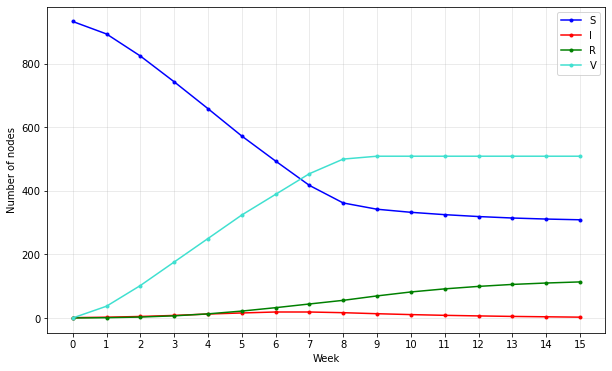

In [23]:
sir_plot(s, i, r, v)

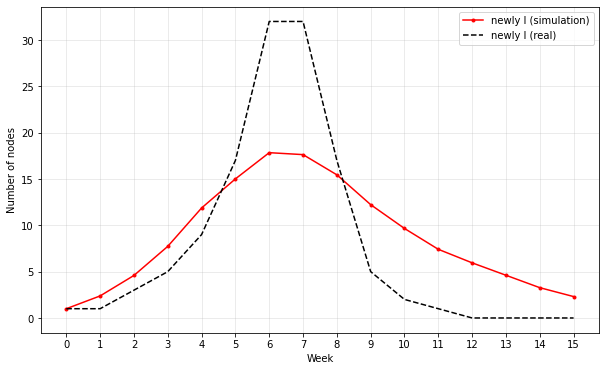

In [24]:
ni_comparison_plot(ni, sweden_ni_target)

The previous plot shows that the Newman-Watts-Strogatz model does not fit the real epidemic trend better than the preferential attachment model. While it partially solves the problem of the epidemic peaking too early, the number of newly infected remains excessively high before and after the peak number of newly infected. Most importantly, the peak number of newly infected is never reached, but remains well under the peak of the real epidemic.

This also sheds a light on the possible inadequacy of the RMSE loss as a cost function for the search algorithm.

In conclusion, we acknowledge that both models have problems in fitting the real epidemic, and more extensive research is needed to find a model and a combination of parameters that fit the trend.